In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

%load_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 30)
pd.set_option('display.max_colwidth', 20)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('Assignment (churn prediction).xlsx')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Country,...,NumberOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Exited
0,747,15787619,Hsieh,844,France,...,1,0,0,145936.28,0
1,1620,15770309,McDonald,656,France,...,1,0,1,127014.32,0
2,1679,15569178,Kharlamov,570,France,...,1,1,0,71811.90,0
3,2022,15795519,Vasiliev,716,Germany,...,1,0,0,197322.13,0
4,2137,15621893,Bellucci,727,France,...,1,1,1,46941.41,0


## Data Exploration
- Check if there are missing values
- Check mixed types
- Explore distribution of features
- Explore relation with target feature

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowNumber         10000 non-null  int64  
 1   CustomerId        10000 non-null  int64  
 2   Surname           10000 non-null  object 
 3   CreditScore       10000 non-null  int64  
 4   Country           10000 non-null  object 
 5   Gender            10000 non-null  object 
 6   Age               10000 non-null  int64  
 7   Tenure            10000 non-null  int64  
 8   CustomerFeedback  3018 non-null   object 
 9   Balance (EUR)     10000 non-null  float64
 10  NumberOfProducts  10000 non-null  int64  
 11  HasCreditCard     10000 non-null  int64  
 12  IsActiveMember    10000 non-null  int64  
 13  EstimatedSalary   10000 non-null  float64
 14  Exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(4)
memory usage: 1.1+ MB


In [5]:
def check_mixed_types(column):
    return column.apply(lambda x: type(x)).nunique() > 1

mixed_type_columns = data.apply(check_mixed_types)
mixed_type_columns

RowNumber           False
CustomerId          False
Surname             False
CreditScore         False
Country             False
Gender              False
Age                 False
Tenure              False
CustomerFeedback     True
Balance (EUR)       False
NumberOfProducts    False
HasCreditCard       False
IsActiveMember      False
EstimatedSalary     False
Exited              False
dtype: bool

### Customer Feedback
- There are missing values and mixed types (nan is considered float)
- We can fill with a N/A symbol

In [6]:
data['CustomerFeedback'] = data['CustomerFeedback'].fillna('N/A')

### Distribution plots
- We want to have a glance on what are the distributions of the features also in relation with the target

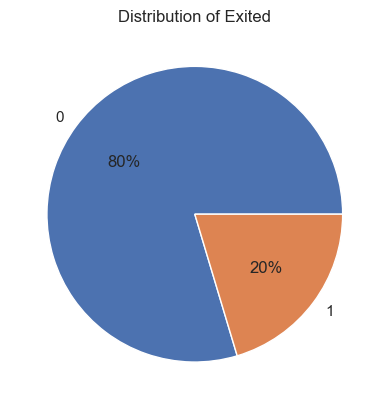

In [8]:
plt.figure()
data_points = data['Exited'].value_counts()
plt.pie(data_points, labels=data_points.index, autopct='%.0f%%')
plt.title('Distribution of Exited')
plt.show()

We can already see that the dataset is fairly unbalanced towards the 0 class (not exited). We will need to address this later.

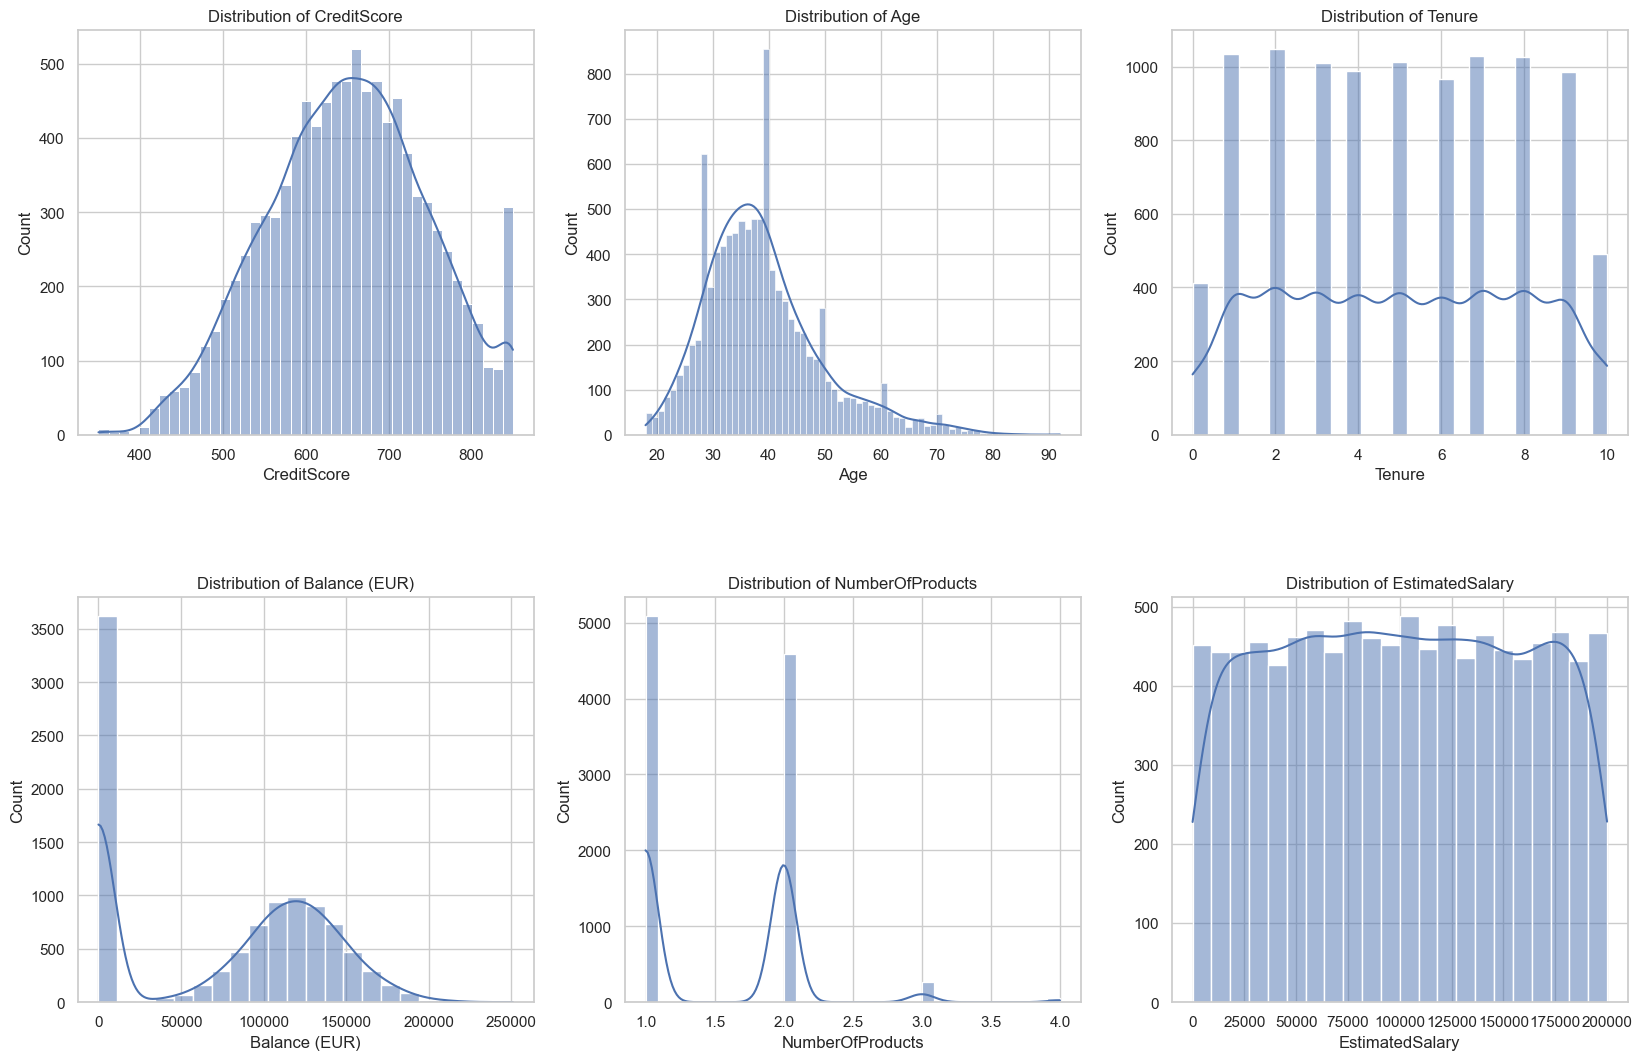

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4)

columns = ['CreditScore', 'Age', 'Tenure', 'Balance (EUR)', 'NumberOfProducts', 'EstimatedSalary']

for idx, col in enumerate(columns):
    ax = axes[idx // 3, idx % 3]
    sns.histplot(data[col], ax=ax, kde=True)
    ax.set_title(f'Distribution of {col}')

for j in range(idx + 1, 3*3):
    fig.delaxes(axes.flatten()[j])

plt.show()

### Comments on distributions
- The values are all in a reasonable range, i.e. the data is not corrupted.
- Credit score has a fairly normal distribution with a mean around 650 and a spike at the maximum value.
- We observe that age distribution follows the developed countries age distribution.
- The tenure is uniformly distributed.
- Balance has a big spike at 0 euro. This means that the majority of the users has not set a balance into the system. I am not sure what is the implications of this. I would need more information about what kind of product this is.
- Estimated salary is uniformly distributed as well as tenure.

### Cross correlation with target

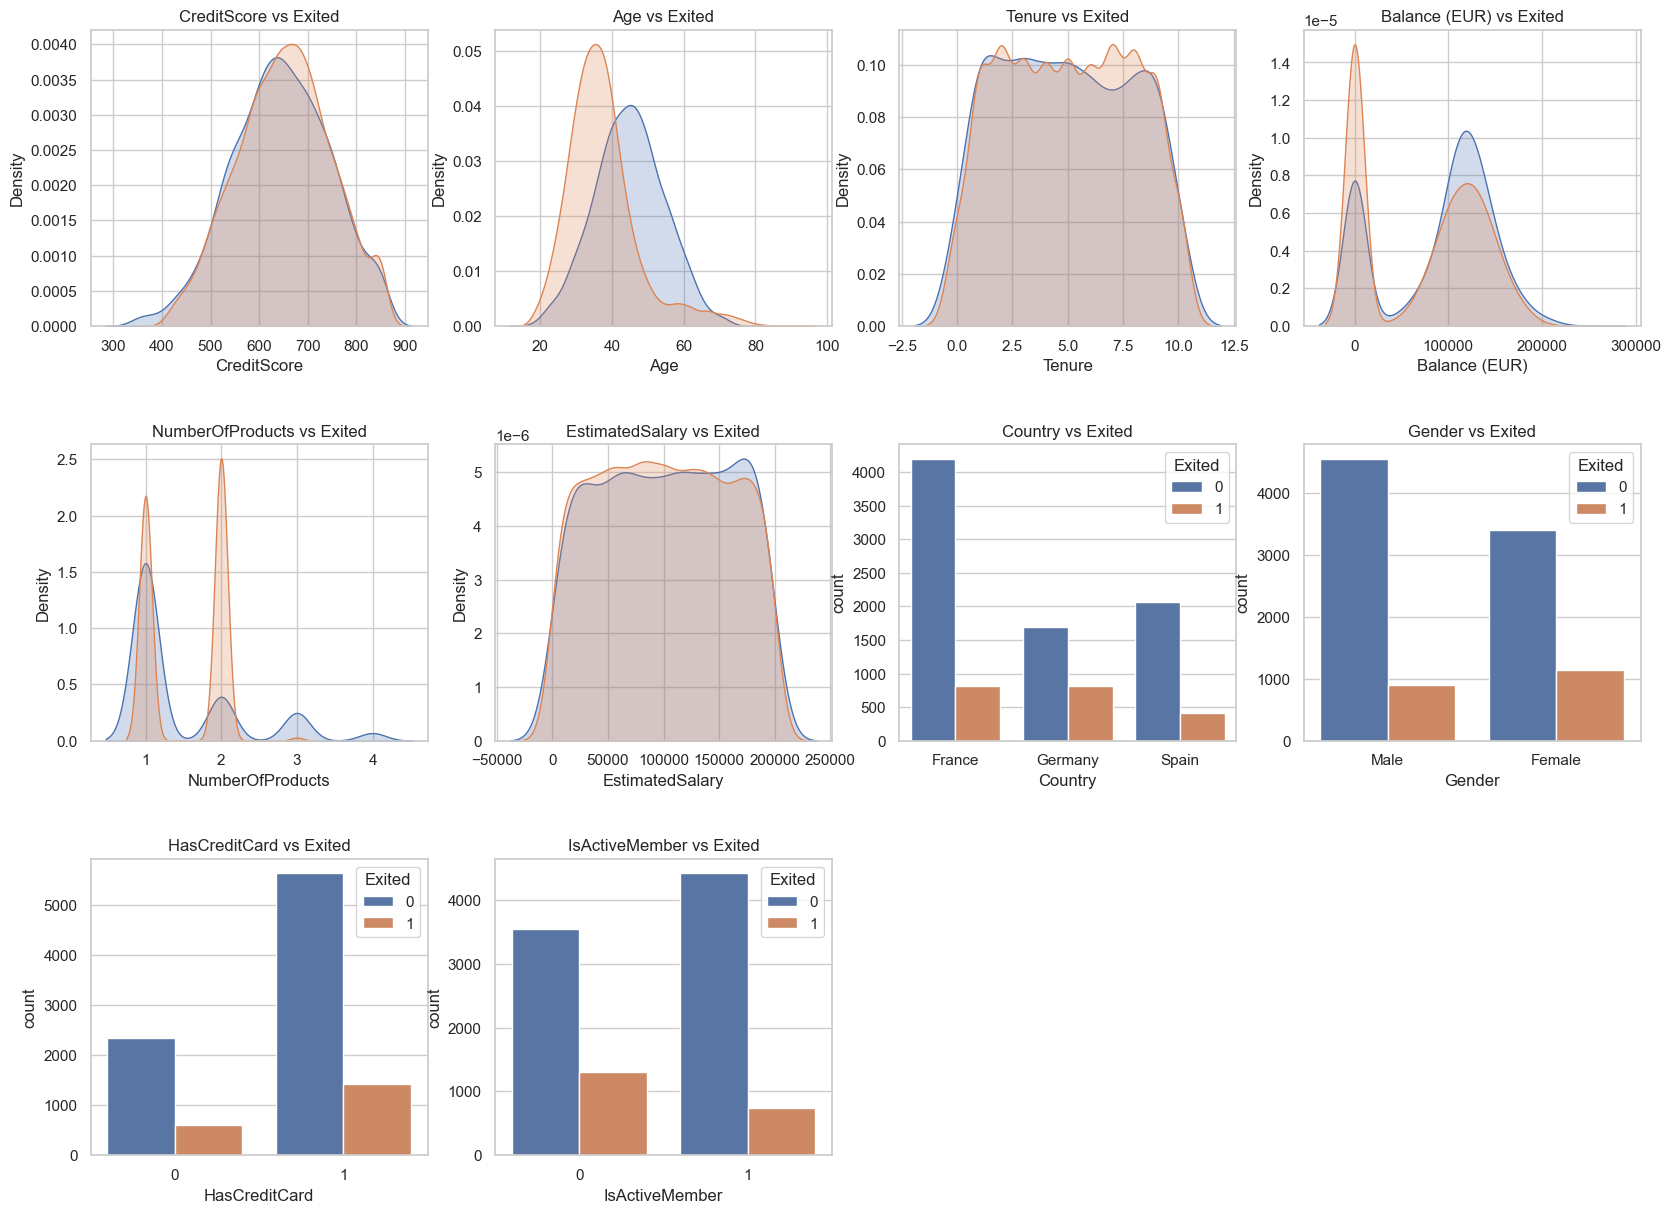

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4)

numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance (EUR)', 'NumberOfProducts', 'EstimatedSalary']
categorical_columns = ['Country', 'Gender', 'HasCreditCard', 'IsActiveMember']

for idx, col in enumerate(numerical_columns):
    ax = axes[idx // 4, idx % 4]
    sns.kdeplot(data[data['Exited'] == 1][col], label='Not Exited', shade=True, ax=ax)
    sns.kdeplot(data[data['Exited'] == 0][col], label='Exited', shade=True, ax=ax)
    ax.set_title(f'{col} vs Exited')

for idx, col in enumerate(categorical_columns, start=len(numerical_columns)):
    ax = axes[idx // 4, idx % 4]
    sns.countplot(x=col, hue='Exited', data=data, ax=ax)
    ax.set_title(f'{col} vs Exited')

for j in range(len(numerical_columns) + len(categorical_columns), 16):
    fig.delaxes(axes.flatten()[j])

plt.show()

### Comments on distributions compared to target
- EstimatedSalary, CreditScore and Tenure do not present significant difference between the exited and not exited distribution.
- We can see that the average age of exited clients is lower meaning that a client of lower age is more likely to exit.
- The double mean distribution of Balance is more skewed for exited users meaning that the behaviour has less variance for exited users.
- Same for NumberOfProducts.
- We can see that both having a credit card and being an active member lead to less exited users.
- No significant difference in gender.
- Apparently french users are less likely to exit with respect to other countries.

## Correlation Analysis
- First we plot the correlation matrix to understand if there are strong correlation between features.
- Then we want to understand which features are more correlated to the target.

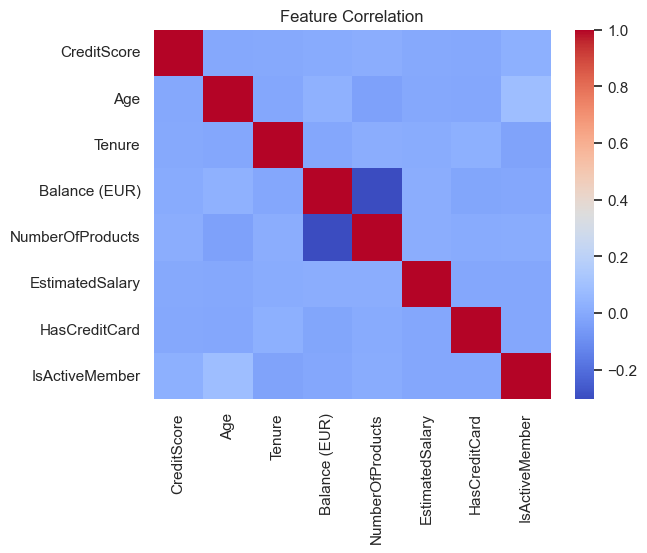

In [11]:
corr_matrix = data[numerical_columns + ['HasCreditCard', 'IsActiveMember']].corr()
plt.figure()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

### Comments
- We do not see particularly high correlation between features.

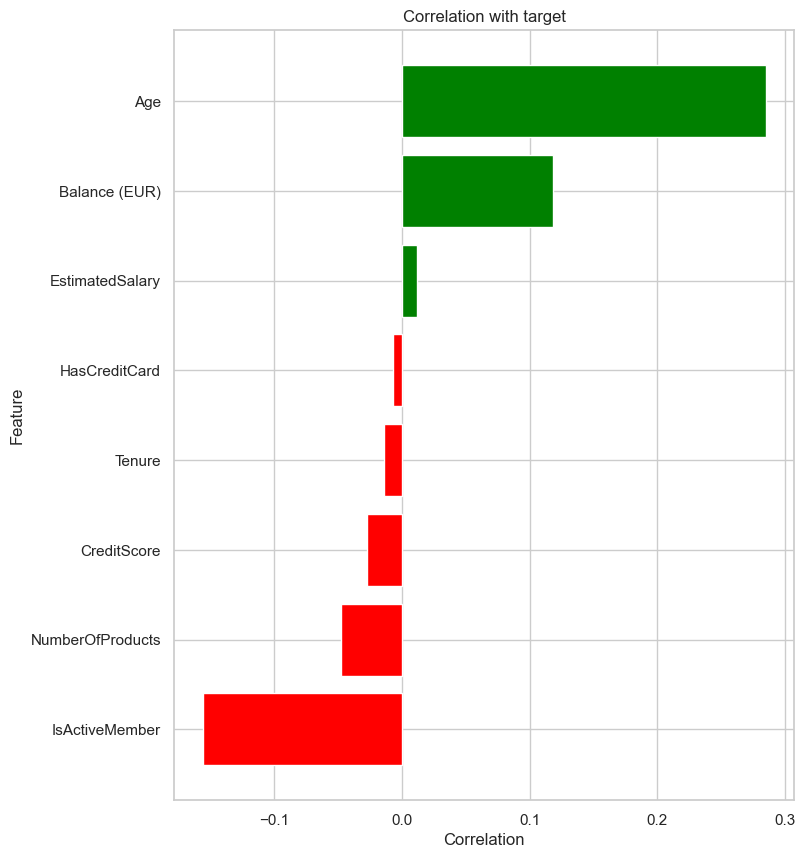

In [12]:
# Build a dataframe with two column: Feature and Correlation representing the correlation between each feature and the target
corr_exited = data[numerical_columns + ['HasCreditCard', 'IsActiveMember', 'Exited']].corr()['Exited']
corr = pd.DataFrame({'Feature': corr_exited.index, 'Correlation': corr_exited.values})
corr = corr[corr['Feature'] != 'Exited']
corr.sort_values(by='Correlation', inplace=True)

# Create the color array with green for positive correlation and red for negative correlation
colors = np.where(corr['Correlation'] > 0, 'green', 'red')
fig, ax = plt.subplots(figsize=(8, 10))

ax.barh(corr['Feature'], corr['Correlation'], color=colors)

ax.set_xlabel('Correlation')
ax.set_ylabel('Feature')
ax.set_title('Correlation with target')

plt.show()

### Comments
- Age positively correlates with the target. This could refer to the previous highlighted fact that a lower age lead to a higher probability of exiting.
- isActiveMember negative correlates with the target, meaning that an active member (1 in the feature) is less likely to leave (1 in the target).

## Feature Engineering
- The goal of this section is to extract useful information about the existing features.
- We want to create new features and possibly manipulate the existing ones.
- First we categorise the age, the balance, the credit score and the estimated salary.
- Than we build a sentiment feature computed from the customer feedback.
- We drop the unused features like RowNumber, Surname, CustomerId

In [41]:
def categorise_feature(feature, percentiles, plot=True):
    thresholds = np.percentile(data[feature], percentiles)
    bin_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    data[f'{feature}_Category'] = pd.cut(data[feature], bins=np.insert(thresholds, 0, data[feature].min()-1), labels=bin_labels, include_lowest=True)
    if plot:
        # Calculate the percentage of Exited within each bin
        bin_counts = data.groupby(f'{feature}_category')['Exited'].value_counts(normalize=True).unstack() * 100
        bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'{feature} Binned Categories vs Exited (Percentage)')
        plt.xlabel(f'{feature} Binned')
        plt.ylabel('Percentage')
        plt.legend(title='Exited', loc='upper right')
        plt.show()

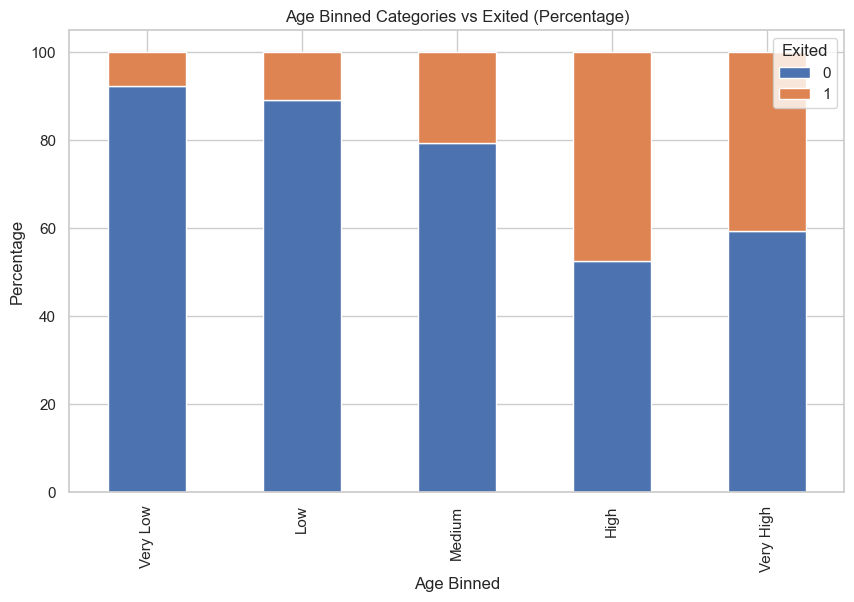

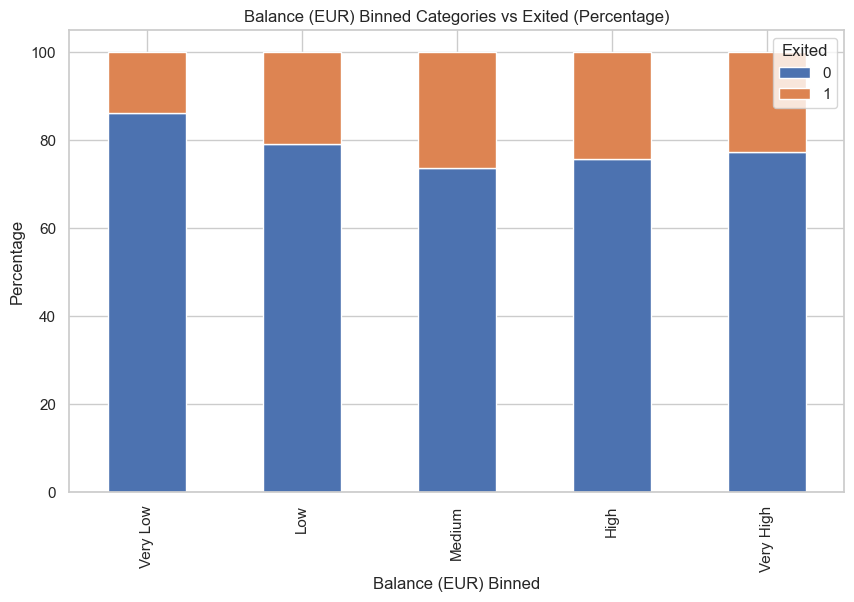

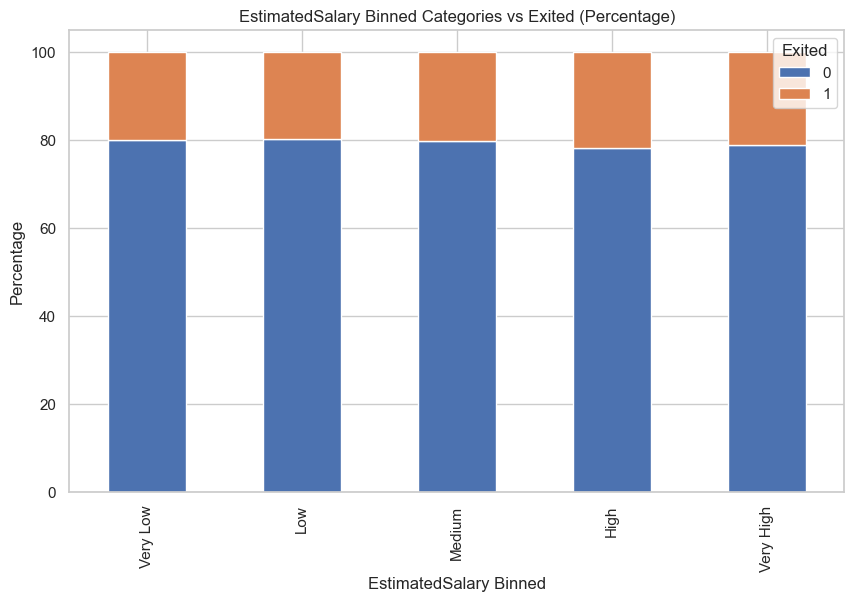

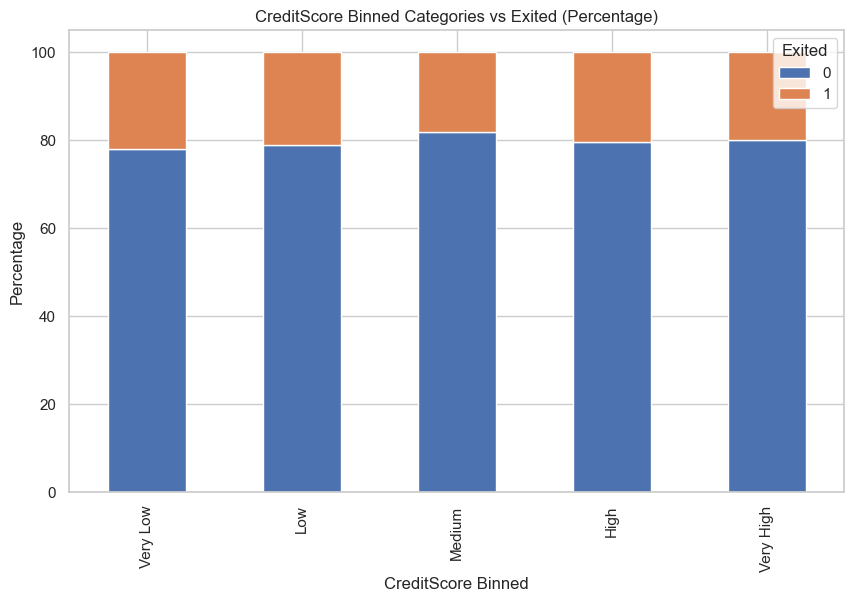

In [39]:
# We compute the bins dinamically with percentiles. 
# This introduce a bias on the prior distribution of this features but it is a better way to categorise rather than handmade thresholds.
percentiles = [25,50,75,90, 100]
numerical_features = ['Age', 'Balance (EUR)', 'EstimatedSalary', 'CreditScore']
for feature in numerical_features:
    categorise_feature(feature, percentiles)

### Comments
- Older people are more likely to exit.
- It seems that there is no clear correlation between the identified bins and the exiting percentage for other features.

In [16]:
from transformers import pipeline
# We selected a public pretrained model specific for customer feedback analysis.
# Its target are POSITIVE, NEGATIVE
# We will put NEUTRAL for missing feedbacks (not commenting is considered a neutral behaviour)
model = pipeline(model="anchit48/fine-tuned-sentiment-analysis-customer-feedback")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [60]:
# We put NEUTRAL also on feedbacks that the model cannot understand very well, i.e. the score is less than 0.6.
def compute_sentiment(feedback):
    if feedback != 'N/A':
        pred = model(feedback)
        if pred[0]['score'] >= 0.6:
            return pred[0]['label']
    return 'NEUTRAL'

In [59]:
data['Sentiment'] = data['CustomerFeedback'].apply(compute_sentiment)

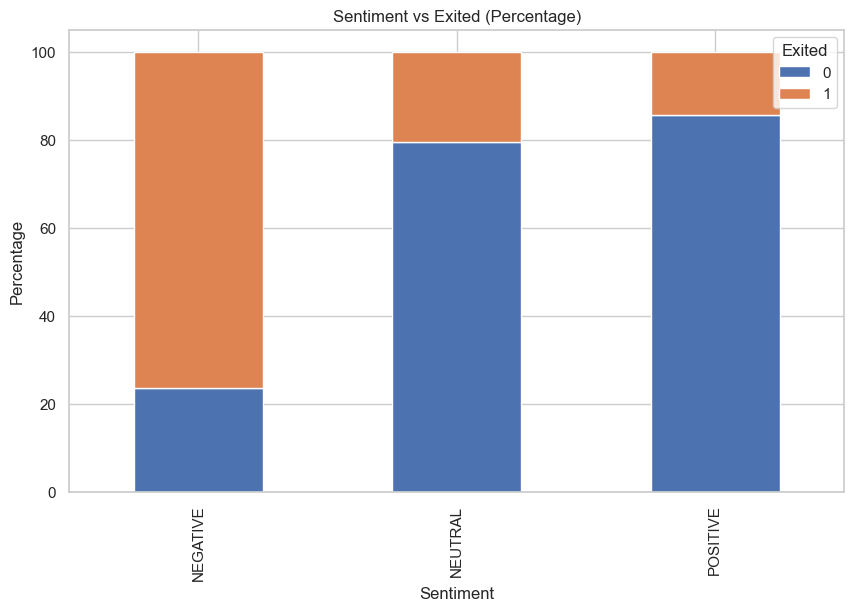

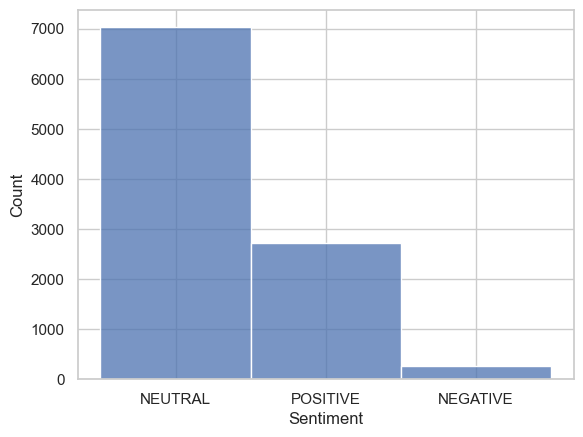

In [61]:
sent_counts = data.groupby('Sentiment')['Exited'].value_counts(normalize=True).unstack() * 100
sent_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment vs Exited (Percentage)')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.legend(title='Exited', loc='upper right')
plt.show()
plt.figure()
sns.histplot(data['Sentiment'], kde=False)
ax.set_title(f'Distribution of Sentiments')
plt.show()

### Comments
- As expected if you leave a negative feedback you are more likely to exit (have exited).

### Store the preprocessed data
- We save the dataset to let us to the next section: modeling.

In [64]:
data.drop(['RowNumber', 'Surname', 'CustomerId', 'CustomerFeedback'], axis=1, inplace=True)

In [65]:
data.to_csv('preprocessed_df.csv', index=False)